---
# Setting
---

In [1]:
# d MyPython/2_Dacon_JEJU/DAT/
# unzip open.zip

In [2]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import numpy as np
from tqdm import tqdm, trange
tqdm.pandas()

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

import itertools
import datetime
from pytimekr import pytimekr
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
import seaborn as sns

import multiprocessing as mp
from joblib import Parallel, delayed

In [3]:
# https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution

import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [4]:
def abline(slope, intercept, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color=color)
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def cnt(x):
    vc = x.value_counts().sort_index()
    res = pd.DataFrame({
        'index' : vc.index,
        'freq'  : vc.values,
    })
    res['rate'] = 100 * res['freq'] / res['freq'].sum()
    return res

In [5]:
os.getcwd()

'/Users/khj/MyPython/Dacon/5_제주도도로교통량예측/PSC'

In [6]:
DAT_PATH = "../DAT/"
start_time = datetime.datetime.now()

print(start_time)

2022-11-04 22:23:45.960220


In [17]:
train_tmp_1['pred_cat'].isnull().sum()
train_tmp_2['pred_cat_kf'].isnull().sum()

60807

<br>

User Functions

In [ ]:
module_path = '../lib'
# module_path = "/Users/khj/StoreLink/MyFunc"
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
from MyModel import *

<br></br>

---
# Data Load
---

- 데이터 설명 <br>
    <img src = attachment:6c04bf7c-fd81-4a79-af3a-41c66c1470c7.png height = 300 width = 350>
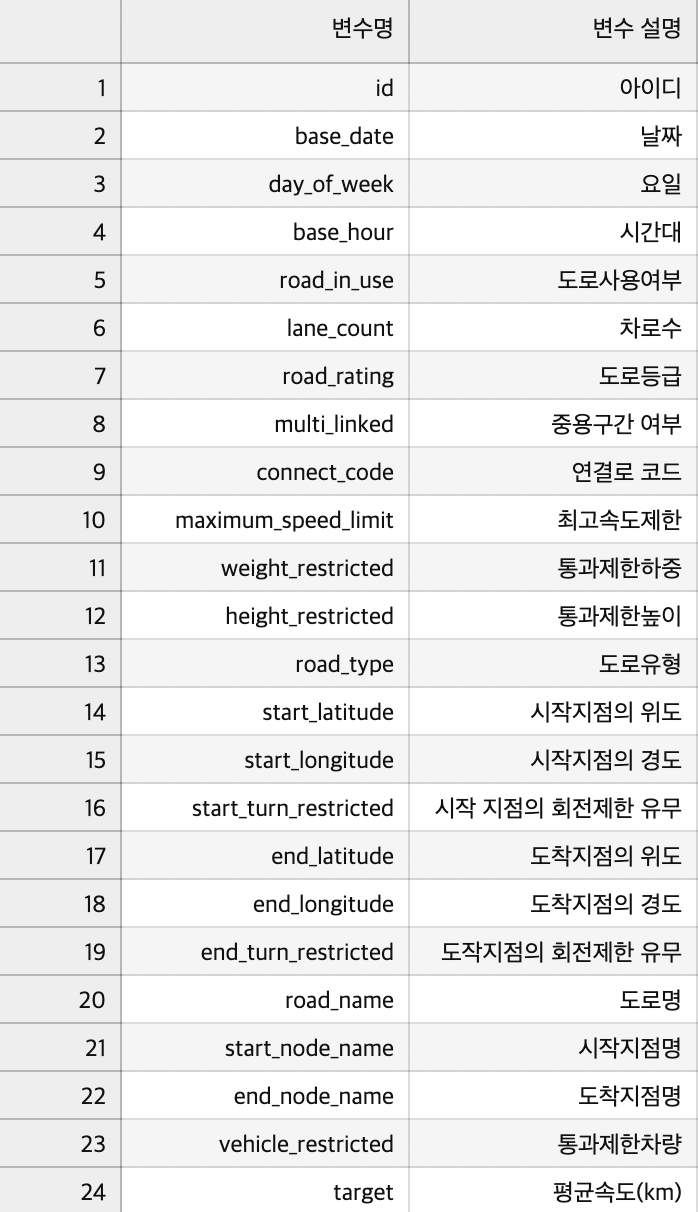

In [ ]:
train_df = pd.read_csv(DAT_PATH+'train.csv')
test_df  = pd.read_csv(DAT_PATH+'test.csv')

<br>

기본적인 내용 확인

In [ ]:
train_df.shape, test_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df.dtypes

In [ ]:
print('\n(1) train')
display(train_df.isnull().sum())

print('\n(2) test')
display(test_df.isnull().sum())

<br>

<br></br>

---
# 분석제외대상
---

<br>

## multi_linked : 중용구간여부
- 단어설명
    - 전용구간 : 하나의 노선이 도로를 전적으로 사용하는 구간
    - 중용구간 : 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간
    - [참조](https://www.semanticscholar.org/paper/%EC%9D%BC%EB%B0%98%EA%B5%AD%EB%8F%84-%EC%A4%91%EC%9A%A9%EA%B5%AC%EA%B0%84%EC%9D%98-%EC%8B%9C%EA%B0%84%EC%A0%81-%EC%A0%95%EB%B3%B4%EA%B4%80%EB%A6%AC%EC%97%90-%EB%8C%80%ED%95%9C-%EC%97%B0%EA%B5%AC-%EC%84%9C%EC%9E%AC%ED%99%94-%EC%84%B1%EC%A0%95%EA%B3%A4/5c905f83ce13879d65c10fc1c92b1ef20d3b402f)
- train은 1이 소수라도 있는 반면, test는 1이 없음
- 대부분이 전용구간이므로, 중용구간은 제외하고 분석하는 것이 좋아보임

In [ ]:
print('\n(1) train')
display(cnt(train_df.multi_linked).round(2))

print('\n(2) test')
display(cnt(test_df.multi_linked).round(2))

<br>

## connect_code : 연결로코드
- train은 103이 소수라도 있는 반면, test는 1이 없음
- 중용구간여부(multi_linked)와는 100% 일치하는 값은 아님
- 하지만, 대부분의 연결로코드가 0으로, 연결로코드 103은 제외하고 분석하는 것이 좋아보임

In [ ]:
print('\n(1) train')
display(cnt(train_df.connect_code).round(2))

print('\n(2) test')
display(cnt(test_df.connect_code).round(2))

In [ ]:
pd.crosstab(train_df.connect_code,train_df.multi_linked)

<br>

## 분석제외대상 삭제

In [ ]:
# 분석제외대상 건수 확인
del_tr_len = train_df.shape[0] - train_df[(train_df.multi_linked==0) & (train_df.connect_code==0)].shape[0]
del_te_len = test_df .shape[0] - test_df [(test_df .multi_linked==0) & (test_df .connect_code==0)].shape[0]
print(f'deleted obs. : train({del_tr_len:,}), test({del_te_len:,})')

# 분석제외대상 삭제
train_df = train_df[(train_df.multi_linked==0) & (train_df.connect_code==0)]
test_df  = test_df [(test_df .multi_linked==0) & (test_df .connect_code==0)]

# 분석제외대상 삭제 후, 해당 컬럼은 모두 동일한 값이므로 삭제

train_df.drop(['multi_linked','connect_code'],axis=1,inplace=True)
test_df .drop(['multi_linked','connect_code'],axis=1,inplace=True)

<br></br>

---
# EDA (1-D)
---

<br>

## id
- 중복된 ID가 없음
- length는 모두 7자리(train), 6자리(test)로 이루어짐

In [ ]:
train_id = pd.Series([x.replace('TRAIN_','') for x in train_df.id])
test_id  = pd.Series([x.replace('TEST_' ,'') for x in test_df .id])

In [ ]:
print('\n(1) id length 확인')
print('- train')
display(train_id.astype(str).apply(len).head())
print('- test')
display(test_id .astype(str).apply(len).head())

print('\n(2) 모든 값은 7자리(train), 6자리(test)로 이루어짐. 즉, 잘못적재된 값 없음')
print('- train')
display(train_id.astype(str).apply(len).value_counts())
print('- test')
display(test_id.astype(str).apply(len).value_counts())

In [ ]:
print('\n(3) 모든 값은 중복되지 않음')
print('- train')
display(cnt(train_id.value_counts()).round(2))

print('- test')
display(cnt(test_id.value_counts()).round(2))

<br>

## base_date : 날짜
- train은 2021-09-01 ~ 2022-07-31, test는 2022-08-01 ~ 2022-08-31로 이루어짐
- train 이후 일자의 데이터가 test로 이루어짐

In [ ]:
train_base_date = pd.Series([datetime.datetime.strptime(str(x),'%Y%m%d') for x in tqdm(train_df.base_date)])
test_base_date  = pd.Series([datetime.datetime.strptime(str(x),'%Y%m%d') for x in tqdm(test_df .base_date)])

In [ ]:
print(f'(1) train 일자 : {train_base_date.min()} ~ {train_base_date.max()}')
print(f'(2) test  일자 : {test_base_date.min()} ~ {test_base_date.max()}')

<br>

## day_of_week : 요일
- train, test 모두 월~금이 비슷한 비율로 들어가있음
- 단, test에서는 월,수가 좀 더 많음

In [ ]:
print('\n(1) train')
display(cnt(train_df.day_of_week).round(2))

print('\n(2) test')
display(cnt(test_df.day_of_week).round(2))

<br>

## base_hour : 시간대
- train, test 모두 0~23의 값으로 들어가있음
- base_date + base_hour의 그룹별로 봤을 때, 딱히 정해진 Freq가 없음 -> 특정 categorical feature로 나뉘는건 아닌 것으로 보임

In [ ]:
print('\n(1) train')
display(cnt(train_df.base_hour))

print('\n(2) test')
display(cnt(test_df.base_hour))

In [ ]:
print('\n<head>')
display(train_df.groupby(['base_date','base_hour']).size().value_counts().sort_index().head())

print('\n<tail>')
display(train_df.groupby(['base_date','base_hour']).size().value_counts().sort_index().tail())

<br>

## road_in_use : 도로사용여부
- 변수 오류로 삭제됨
- 참조 : [Dacon](https://dacon.io/competitions/official/235985/talkboard/407092?page=1&dtype=recent)

<br>

## lane_count : 차로수
- train, test 모두 1,2,3의 값이 들어가있음
- train의 빈도는 2>1>3인 반면, test의 빈도는 2>3>1으로 이루어짐
- categorical로 넣을지, integer로 넣을지 고민 필요

In [ ]:
print('\n(1) train')
display(cnt(train_df.lane_count).round(2))

print('\n(2) test')
display(cnt(test_df.lane_count).round(2))

<br>

## road_rating : 도로등급
- train, test 모두 103,106,107으로 이루어짐
- train의 빈도는 1>3>2인 반면, test의 빈도는 3>1>2로 이루어짐
- categorical로 변경 필요

In [ ]:
print('\n(1) train')
display(cnt(train_df.road_rating).round(2))

print('\n(2) test')
display(cnt(test_df.road_rating).round(2))

<br>

## maximum_speed_limit : 최고속도제한
- 기존에는 train은 40.0이 있는 반면, test는 40.0이 없었음
- multi_linked, connect_code에서 분석제외대상을 제거 한 이후에 동일하게 나타남

In [ ]:
print('\n(1) train')
display(cnt(train_df.maximum_speed_limit).round(2))

print('\n(2) test')
display(cnt(test_df.maximum_speed_limit).round(2))

<br>

## weight_restricted : 통과제한하중
- 큰 문제 없음

In [ ]:
print('\n(1) train')
display(cnt(train_df.weight_restricted).round(2))

print('\n(2) test')
display(cnt(test_df.weight_restricted).round(2))

<br>

## height_restricted : 통과제한높이
- train, test 모두 0으로 이루어짐
- 모두 동일한 값이므로, 분석대상에서 제외

In [ ]:
print('\n(1) train')
display(cnt(train_df.height_restricted).round(2))

print('\n(2) test')
display(cnt(test_df.height_restricted).round(2))

<br>

## road_type : 도로유형
- 큰 문제 없음

In [ ]:
print('\n(1) train')
display(cnt(train_df.road_type).round(2))

print('\n(2) test')
display(cnt(test_df.road_type).round(2))

<br>

## start_latitude : 시작지점 위도
- 분포가 조금 달라보임
- train은 중간부분에 값이 있는데, test는 중간부분에 값이 거의 없음

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
sns.violinplot(y=train_df.start_latitude)
plt.title('train')

ax2 = fig.add_subplot(1,2,2)
sns.violinplot(y=test_df.start_latitude)
plt.title('test')

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])

plt.show()

<br>

## start_longitude : 시작지점 경도
- 분포가 조금 달라보임
- train은 양끝쪽에 값이 있는 반면, test는 양끝쪽에 값이 많이 없음

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
sns.violinplot(y=train_df.start_longitude)
plt.title('train')

ax2 = fig.add_subplot(1,2,2)
sns.violinplot(y=test_df.start_longitude)
plt.title('test')

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])

plt.show()

<br>

## start_turn_restricted : 시작지점 회전제한 유무
- test의 있음이 비중이 좀 더 높음

In [ ]:
print('\n(1) train')
display(cnt(train_df.start_turn_restricted).round(2))

print('\n(2) test')
display(cnt(test_df.start_turn_restricted).round(2))

<br>

## end_latitude : 도착지점 위도
- 분포가 조금 달라보임
- train은 중간부분에 값이 있는데, test는 중간부분에 값이 거의 없음

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
sns.violinplot(y=train_df.end_latitude)
plt.title('train')

ax2 = fig.add_subplot(1,2,2)
sns.violinplot(y=test_df.end_latitude)
plt.title('test')

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])

plt.show()

<br>

## end_longitude : 도착지점 경도
- 분포가 조금 달라보임
- train은 양끝쪽에 값이 있는 반면, test는 양끝쪽에 값이 많이 없음

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
sns.violinplot(y=train_df.end_longitude)
plt.title('train')

ax2 = fig.add_subplot(1,2,2)
sns.violinplot(y=test_df.end_longitude)
plt.title('test')

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])

plt.show()

In [ ]:
train_df[['start_latitude','start_longitude','end_latitude','end_longitude']].corr().round(4)*100

<br>

- latitude와 longitude간에 상관관계가 매우 높으므로 다공선성의 문제가 생길 가능성이 있음
    - start와 end의 차이는 매우 작은 값이기 때문에, start나 end 하나만 사용해도 좋을 것으로 보임
    - 정보손실을 최소화하기 위해서, start,end 중 하나를 삭제하고, start와 end의 차이를 사용
    - 차이값과 start만 사용했을 때, 상관관계가 낮아서 다공선성에 안전할 것으로 보임

In [ ]:
tmp = pd.DataFrame({
    # 'latitude_prod'  : train_df.start_latitude*train_df.end_latitude,
    # 'longitude_prod' : train_df.start_longitude*train_df.end_longitude
    'latitude_diff'  : train_df.end_latitude - train_df.start_latitude,
    'longitude_diff' : train_df.end_longitude - train_df.start_longitude,
    'start_longitude' : train_df.start_longitude,
    'start_latitude' : train_df.start_latitude,
})

print('(1) correlation')
display(tmp.corr().round(4)*100)

print('\n(2) boxplot')
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.boxplot(y=tmp['latitude_diff'])
fig.add_subplot(122)
sns.boxplot(y=tmp['longitude_diff'])
plt.show()

<br>

start와 end의 차이가 0인 값들 확인

In [ ]:
tmp = train_df[['start_latitude','end_latitude']]
tmp['diff'] = train_df['end_latitude'] - train_df['start_latitude']

print('(1) describe')
display(tmp.describe().round(3))

In [ ]:
tr_tmp = pd.DataFrame({
    # 'latitude_prod'  : train_df.start_latitude*train_df.end_latitude,
    # 'longitude_prod' : train_df.start_longitude*train_df.end_longitude
    'latitude_diff'  : train_df.end_latitude - train_df.start_latitude,
    'longitude_diff' : train_df.end_longitude - train_df.start_longitude,
})
te_tmp = pd.DataFrame({
    # 'latitude_prod'  : test_df.start_latitude*test_df.end_latitude,
    # 'longitude_prod' : test_df.start_longitude*test_df.end_longitude
    'latitude_diff'  : test_df.end_latitude - test_df.start_latitude,
    'longitude_diff' : test_df.end_longitude - test_df.start_longitude,
})

offset = 1e-5
tr_equal_latitude_freq  = np.where(abs(tr_tmp.latitude_diff) <offset,1,0).sum()
te_equal_latitude_freq  = np.where(abs(te_tmp.latitude_diff) <offset,1,0).sum()
tr_equal_longitude_freq = np.where(abs(tr_tmp.longitude_diff)<offset,1,0).sum()
te_equal_longitude_freq = np.where(abs(te_tmp.longitude_diff)<offset,1,0).sum()

tr_total_freq = train_df.shape[0]
te_total_freq = test_df .shape[0]

print(f'Freq. of (start_latitude == end_latitude)')
print(f'- train : {tr_equal_latitude_freq:,} ({tr_equal_latitude_freq/tr_total_freq*100:.2f}%)')
print(f'- train : {te_equal_latitude_freq:,} ({te_equal_latitude_freq/te_total_freq*100:.2f}%)')

<br>

## end_turn_restricted : 도착지점 회전제한 유무
- test의 있음이 비중이 좀 더 높음
- start_turn_restricted와 end_turn_restricted는 대부분 없음임
- 두 feature와의 관계는 크게있지는 않아보임

In [ ]:
print('\n(1) train')
display(cnt(train_df.end_turn_restricted).round(2))

print('\n(2) test')
display(cnt(test_df.end_turn_restricted).round(2))

In [ ]:
tr_ct = pd.crosstab(train_df['start_turn_restricted'],train_df['end_turn_restricted'])
te_ct = pd.crosstab(test_df ['start_turn_restricted'],test_df ['end_turn_restricted'])

In [ ]:
fig = plt.figure(figsize=(15,7))

fig.add_subplot(121)
ax = sns.heatmap(tr_ct,cmap='Blues',annot=True,fmt='d')
plt.title('<train>',size=15)
total_freq = sum([int(t.get_text()) for t in ax.texts])
for t in ax.texts:
    t.set_text('{:,d}\n({:.2f}%)'.format(int(t.get_text()), 100*int(t.get_text())/total_freq))

fig.add_subplot(122)
ax = sns.heatmap(te_ct,cmap='Blues',annot=True,fmt='d')
plt.title('<test>',size=15)
total_freq = sum([int(t.get_text()) for t in ax.texts])
for t in ax.texts:
    t.set_text('{:,d}\n({:.2f}%)'.format(int(t.get_text()), 100*int(t.get_text())/total_freq))
    
plt.tight_layout()
plt.show()

<br>

## road_name : 도로명
- train에 없고 test에만 존재하는 도로명은 없음
- train에서 도로명은 총 61가지

In [ ]:
train_df.road_name.nunique(), test_df.road_name.nunique()

In [ ]:
tr_road_name = train_df.road_name.unique()
te_road_name = test_df .road_name.unique()

print(f'train에만 있는 도로명 : {list(set(tr_road_name)-set(te_road_name))}')
print(f'test 에만 있는 도로명 : {list(set(te_road_name)-set(tr_road_name))}')

<br>

## start_node_name : 시작지점명
- train에 없고 test에만 존재하는 시작지점명은 없음
- train에서 시작지점명은 총 486가지로 매우 많음

In [ ]:
train_df.start_node_name.nunique(), test_df.start_node_name.nunique()

In [ ]:
tr_start_node_name = train_df.start_node_name.unique()
te_start_node_name = test_df .start_node_name.unique()

print(f'train에만 있는 시작지점명 : {list(set(tr_start_node_name)-set(te_start_node_name))}')
print(f'test 에만 있는 시작지점명 : {list(set(te_start_node_name)-set(tr_start_node_name))}')

<br>

## end_node_name : 도착지점명
- train에 없고 test에만 존재하는 도착지점명은 없음
- train에서 도착지점명은 총 486가지로 매우 많음
- train에서 (시작지점명,도착지점명)의 조합은 806개로 매우 많음
- 시작지점명과 도착지점명이 동일한 비중은 train(19.73%), test(18.24%)

In [ ]:
train_df.end_node_name.nunique(), test_df.end_node_name.nunique()

In [ ]:
tr_end_node_name = train_df.end_node_name.unique()
te_end_node_name = test_df .end_node_name.unique()

print(f'train에만 있는 시작지점명 : {list(set(tr_end_node_name)-set(te_end_node_name))}')
print(f'test 에만 있는 시작지점명 : {list(set(te_end_node_name)-set(tr_end_node_name))}')

In [ ]:
len(train_df.groupby(['road_type','start_node_name','end_node_name']).size().sort_values().values)

In [ ]:
tr_equal_node_freq = np.where(train_df.start_node_name==train_df.end_node_name,1,0).sum()
te_equal_node_freq = np.where(test_df .start_node_name==test_df .end_node_name,1,0).sum()
tr_total_freq = train_df.shape[0]
te_total_freq = test_df .shape[0]

print(f'Freq. of (start_node_name == end_node_name)')
print(f'- train : {tr_equal_node_freq:,} ({tr_equal_node_freq/tr_total_freq*100:.2f}%)')
print(f'- train : {te_equal_node_freq:,} ({te_equal_node_freq/te_total_freq*100:.2f}%)')

In [ ]:
# train_df[train_df.start_node_name==train_df.end_node_name].head()

<br>

## vehicle_restricted : 통과제한차량
- train, test 모두 0으로 이루어짐

In [ ]:
print('\n(1) train')
display(cnt(train_df.vehicle_restricted).round(2))

print('\n(2) test')
display(cnt(test_df.vehicle_restricted).round(2))

<br>

## target : 평균속도(km)
- 어느정도 normal distribution의 형태를 보임

In [ ]:
fig = plt.figure(figsize=(8,7))
sns.violinplot(y=train_df.target)
plt.title('train')
plt.show()

<br></br>

<br></br>

---
# EDA (2-D)
---
- 전처리 후 2-D EDA 진행

In [ ]:
train_df.apply(lambda x: x.nunique())

In [ ]:
# hour_string = ['0'+str(x) if len(str(x))==1 else
#                str(x)     if len(str(x))==2 else
#                np.nan for x in train_df.base_hour]

# date_string = train_df.base_date.astype(str) + ' ' + hour_string + ':00:00'

# vc = pd.Series(date_string).value_counts()

In [ ]:
def DataPreprocessing(data):
    d = data.copy()
    #d = d.sort_values(['base_date','base_hour'])
    
    # # (1) id 컬럼 삭제
    # d.drop('id',axis=1,inplace=True)
    
    # (2) base_date : int to datetime
    d.base_date = [datetime.datetime.strptime(str(x),'%Y%m%d') for x in d.base_date]

    #+날짜관련 변수추가
    # (2-1) 기본적인 날짜 변수 추가
    d['year']    = d.base_date.dt.year
    d['quarter'] = d.base_date.dt.quarter
    d['month']   = d.base_date.dt.month
    d['day']     = d.base_date.dt.day
    d['weekday'] = d.base_date.dt.weekday
    d['weekend'] = np.where((d['weekday']==5) | (d['weekday']==6),1,0)

    # (2-2) 공휴일 변수 추가
    year_list = d['year'].unique()
    holiday_list = []
    for year in year_list:
        h_list = pytimekr.holidays(year)
        holiday_list.append(h_list)

    holiday_list = list(itertools.chain(*holiday_list))
    d['holiday'] = np.where(d.base_date.isin(holiday_list),1,0)

    # (2-3) 일자관련 컬럼 -> string으로 변경
    date_feature = ['year','quarter','month','day','weekday','weekend','holiday']
    astype_dict  = dict([(f,str) for f in date_feature])
    d = d.astype(astype_dict)
    
    # # (3) day_of_week : string to int
    # d.day_of_week = d.day_of_week.map({
    #     '월' : 0,
    #     '화' : 1,
    #     '수' : 2,
    #     '목' : 3,
    #     '금' : 4,
    #     '토' : 5,
    #     '일' : 6,
    # }).astype(str)

    # # (4) date_column 삭제
    # d.drop('base_date',axis=1,inplace=True)
    
    # (5) base_hour
    # base_date에 base_hour 연결해서 새로운 날짜컬럼 만들기
    # -> 굳이 필요없을 것으로 보임
    
    # (6) latitude, longitude
    # - latitude, longitude에서 start,end 간에 선형관계가 크므로, 차이값(end-start)을 사용
    # - 또한, 차이값(end-start)는 매우 작은 값이므로, 정보손실을 최소화하기 위해서 start,end 중에서 end를 제외한 start만을 사용
    d['latitude_diff'] = d.end_latitude - d.start_latitude
    d['longitude_diff'] = d.end_longitude - d.start_longitude
    d.drop(['end_latitude','end_longitude'],axis=1,inplace=True)
    
    # (7) int to string
    d.maximum_speed_limit = d.maximum_speed_limit.astype(int)
    d.weight_restricted   = d.weight_restricted.astype(int)
    
    int2str_features = ['base_hour','lane_count','road_rating','maximum_speed_limit','weight_restricted','road_type']
    int2str_dict = dict([(x,str) for x in int2str_features])
    d = d.astype(int2str_dict)
    
    # (8) only one value
    d.drop(['height_restricted','vehicle_restricted'],axis=1,inplace=True)
    
    # # (9) string to int
    # d.start_turn_restricted = d.start_turn_restricted.map({
    #     '없음' : 0,
    #     '있음' : 1,
    # }).astype(str)

    # d.end_turn_restricted = d.end_turn_restricted.map({
    #     '없음' : 0,
    #     '있음' : 1,
    # }).astype(str)
    
    # (10) 시작지점명과 도착지점명이 동일한지 여부
    d['equal_node_name'] = np.where(d.start_node_name == d.end_node_name,'1','0')
    
    # (11) 
    # - test에서 2022-08 밖에 없으므로, year, quarter, month는 제외
    # - day_of_week는 weekday와 동일하므로 제외
    d.drop(['year','quarter','month','day_of_week'],axis=1,inplace=True)
    
    return d

In [ ]:
%%time
# 1분

train_df2 = DataPreprocessing(train_df)
test_df2  = DataPreprocessing(test_df)

In [ ]:
cat_features = train_df2\
    .drop(['id','base_date'],axis=1)\
    .select_dtypes(include=[object])\
    .columns.tolist()

num_features = [x for x in train_df2.drop(['id','target','base_date'],axis=1).columns if x not in cat_features]

In [ ]:
print('\n(1) categorical features : ',cat_features)
print('\n(2) numerical features   : ',num_features)

<br>

## target vs categorical features
- boxplot으로 봤을 때, target에 어느정도 유의해보이는 변수
    - lane_count
    - road_rating
    - maximum_speed_limit
    - weight_restricted
    - road_type
    - start_turn_restricted
    - end_turn_restricted
    - equal_node_name


- 유의해보이지 않는 변수
    - day
    - weekday
    - weekend
    - holiday

In [ ]:
# %%time
# # 13분

# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # 3시간 간격, lane_count, road_rating, maximum_speed_limit, road_type, start_turn_restricted

# anova_list = []
# iter = 0
# for col in cat_features:
#     iter+=1
#     print(f'\n({iter}/{len(cat_features)}) {col}')
#     if train_df2[col].nunique()>40:
#         print('nunique > 40')
#     else:
#         # Ordinary Least Squares (OLS) model
#         model = ols(f'target ~ C({col})', data=train_df2).fit()
#         anova_table = sm.stats.anova_lm(model, typ=2)
#         fvalue = anova_table['F'][0]
#         pvalue = anova_table['PR(>F)'][0]
#         anova_list.append([col,fvalue,pvalue])
        
#         fig = plt.figure(figsize=(15,7))
#         fig.add_subplot(121)
#         sns.boxplot(train_df2[col],train_df2.target)
#         plt.title('target')
#         fig.add_subplot(122)
#         sns.boxplot(train_df2[col],np.log(train_df2.target))
#         plt.title('log(target)')
#         plt.suptitle(f'F-stats.={fvalue:.4f}, p-value={pvalue:.4f}')
#         plt.show()

In [ ]:
# %%time
# # 13분

# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # 3시간 간격, lane_count, road_rating, maximum_speed_limit, road_type, start_turn_restricted

# def func(iter):
#     col = cat_features[iter]
    
#     if train_df2[col].nunique()>40:
#         print('nunique > 40')
        
#         return None
        
#     else:
#         # Ordinary Least Squares (OLS) model
#         model = ols(f'target ~ C({col})', data=train_df2).fit()
#         anova_table = sm.stats.anova_lm(model, typ=2)
#         fvalue = anova_table['F'][0]
#         pvalue = anova_table['PR(>F)'][0]
        
#         fig = plt.figure(figsize=(15,7))
#         fig.add_subplot(121)
#         sns.boxplot(train_df2[col],train_df2.target)
#         plt.title('target')
#         fig.add_subplot(122)
#         sns.boxplot(train_df2[col],np.log(train_df2.target))
#         plt.title('log(target)')
#         plt.suptitle(f'F-stats.={fvalue:.4f}, p-value={pvalue:.4f}')
#         plt.show()
        
#         return [col,fvalue,pvalue]

# with tqdm_joblib(tqdm(total=len(cat_features))) as progress_bar:
#     anova_list = Parallel(n_jobs=mp.cpu_count())(delayed(func)(i) for i in range(len(cat_features)))

<br>

추가

In [ ]:
# # (1) 3시간 간격 시간대
# tmp_df = pd.DataFrame()

# tmp_df['target'] = train_df2.target
# tmp_df['base_hour_3_interval'] = [
#     '0' if int(x)<=3  else 
#     '1' if int(x)<=6  else
#     '2' if int(x)<=9  else
#     '3' if int(x)<=12 else
#     '4' if int(x)<=15 else
#     '5' if int(x)<=18 else
#     '6' if int(x)<=21 else
#     '7' if int(x)<=24 else
#     np.nan for x in train_df2['base_hour']
# ]
# # pd.Series(tmp_df['base_hour_3_interval']).value_counts().sort_index()

# # Ordinary Least Squares (OLS) model
# model = ols(f'target ~ C(base_hour_3_interval)', data=tmp_df).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# fvalue = anova_table['F'][0]
# pvalue = anova_table['PR(>F)'][0]
# anova_list.append(['base_hour_3_interval',fvalue,pvalue])

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.boxplot(tmp_df.base_hour_3_interval,tmp_df.target,order=[str(x) for x in range(8)])
# plt.title('target')
# fig.add_subplot(122)
# sns.boxplot(tmp_df.base_hour_3_interval,np.log(tmp_df.target),order=[str(x) for x in range(8)])
# plt.title('log(target)')
# plt.suptitle(f'F-stats.={fvalue:.4f}, p-value={pvalue:.4f}')
# plt.show()

In [ ]:
# # (2) 일요일 vs 나머지
# tmp_df = pd.DataFrame()

# tmp_df['target'] = train_df2.target
# tmp_df['is_sunday'] = [
#     '0' if x=='6' else '1'
#     for x in train_df2['weekday']
# ]
# # pd.Series(tmp_df['is_sunday']).value_counts().sort_index()

# # Ordinary Least Squares (OLS) model
# model = ols(f'target ~ C(is_sunday)', data=tmp_df).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# fvalue = anova_table['F'][0]
# pvalue = anova_table['PR(>F)'][0]
# anova_list.append(['is_sunday',fvalue,pvalue])

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.boxplot(tmp_df.is_sunday,tmp_df.target,order=[str(x) for x in range(2)])
# plt.title('target')
# fig.add_subplot(122)
# sns.boxplot(tmp_df.is_sunday,np.log(tmp_df.target),order=[str(x) for x in range(2)])
# plt.title('log(target)')
# plt.suptitle(f'F-stats.={fvalue:.4f}, p-value={pvalue:.4f}')
# plt.show()

In [ ]:
# # (3) start_turn_restricted + end_turn_restricted
# tmp_df = pd.DataFrame()

# tmp_df['target'] = train_df2.target
# tmp_df['turn_restricted'] = train_df2['start_turn_restricted'] +'_'+ train_df2['end_turn_restricted']
# # pd.Series(tmp_df['turn_restricted']).value_counts().sort_index()

# # Ordinary Least Squares (OLS) model
# model = ols(f'target ~ C(turn_restricted)', data=tmp_df).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# fvalue = anova_table['F'][0]
# pvalue = anova_table['PR(>F)'][0]
# anova_list.append(['turn_restricted',fvalue,pvalue])

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.boxplot(tmp_df.turn_restricted,tmp_df.target,order=[str(x) for x in range(2)])
# plt.title('target')
# fig.add_subplot(122)
# sns.boxplot(tmp_df.turn_restricted,np.log(tmp_df.target),order=[str(x) for x in range(2)])
# plt.title('log(target)')
# plt.suptitle(f'F-stats.={fvalue:.4f}, p-value={pvalue:.4f}')
# plt.show()

In [ ]:
# anova_df = pd.DataFrame(anova_list,columns=['feature','fvalue','pvalue'])\
#     .sort_values('fvalue')
# anova_df.to_csv('../OUT/anova_df.csv',index=False)

anova_df = pd.read_csv('../OUT/anova_df.csv')
anova_df.round(2)

<br>

## target vs numerical features

In [ ]:
train_df2[num_features+['target']].corr()

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_df2.start_latitude,train_df2.start_longitude)
sns.scatterplot(train_df2.start_latitude[:1],train_df2.start_longitude[:1],color='red')
plt.show()

In [ ]:
# 구글지도에서 위도,경도 확인
# https://www.google.com/maps/place/33%C2%B025'39.9%22N+126%C2%B039'45.4%22E/data=!4m5!3m4!1s0x0:0xe783ccef5cd9b938!8m2!3d33.427747!4d126.662612
train_df2[['start_latitude','start_longitude']].head()

In [ ]:
# 겹친게 생각보다 많음
print('\n(1) latitude_diff')
print('<head>')
display(train_df2['start_latitude'].value_counts().value_counts().sort_index().head())
print('<tail>')
display(train_df2['start_latitude'].value_counts().value_counts().sort_index().tail())

print('\n(2) latitude_diff')
print('<head>')
display(train_df2['start_longitude'].value_counts().value_counts().sort_index().head())
print('<tail>')
display(train_df2['start_longitude'].value_counts().value_counts().sort_index().tail())

print('\n(3) latitude_diff')
print('<head>')
display(train_df2['latitude_diff'].value_counts().value_counts().sort_index().head())
print('<tail>')
display(train_df2['latitude_diff'].value_counts().value_counts().sort_index().tail())

print('\n(4) longitude_diff')
print('<head>')
display(train_df2['longitude_diff'].value_counts().value_counts().sort_index().head())
print('<tail>')
display(train_df2['longitude_diff'].value_counts().value_counts().sort_index().tail())

In [ ]:
for col in num_features:
    fig = plt.figure(figsize=(15,7))
    sns.scatterplot(train_df2[col],train_df2.target,alpha=0.5)
    plt.title(col)
    plt.show()

<br></br>

---
# Segmentation
---

- boxplot 확인 시, 유의했던 categorical 변수
    - lane_count : 차로수
    - road_rating : 도로등급
    - maximum_speed_limit : 최고속도제한
    - weight_restricted : 통과제한하중
    - road_type : 도로유형
    - start_turn_restricted : 시작지점 회전제한 유무
    - end_turn_restricted : 도착지점 회전제한 유무
    - equal_node_name : 시작지점과 도착지점 일치여부

In [ ]:
# cat_features, num_features

seg_size = 3
seg_features = anova_df.sort_values('fvalue',ascending=False).feature.values[:seg_size]
display(anova_df.sort_values('fvalue',ascending=False)[:seg_size])

segment = train_df2[seg_features].progress_apply(lambda x: '_'.join(x),axis=1)

print('segment nunique :', segment.nunique())
print('segment freq. : <head>')
display(segment.value_counts().head())
print('segment freq. : <tail>')
display(segment.value_counts().tail())

In [ ]:
# plt.figure(figsize=(15,30))
# ax = sns.boxplot(segment,train_df2.target)
# ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
# plt.show()

<br></br>

# Weather API

<br>

## 위도와 경도에 따른 주소 가져오기
- [참조](https://parkgihyeon.github.io/project/geocoding-api/)

In [ ]:
# %%time
# # 5분

# # 가입 없이 좌표->주소 변환
# from geopy.geocoders import Nominatim

# def geocoding_reverse(lat_lng_str): 
#     geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
#     address = geolocoder.reverse(lat_lng_str)
#     return address

# # address = geocoding_reverse('36.5760732781656, 128.15935928504484')
# # print(address)

# # lat_lng_str = train_df['start_latitude'].astype(str) +', '+ train_df['start_longitude'].astype(str)
# # lat_lng_str.progress_apply(geocoding_reverse).head()

# duplicated_df = train_df\
#     [['start_latitude','start_longitude']]\
#     .drop_duplicates()

# address_df = duplicated_df\
#     .progress_apply(lambda x: 
#         str(geocoding_reverse(x['start_latitude'].astype(str)+','+str(x['start_longitude']))),
#         axis=1
#     )

# address_df = pd.concat([
#     duplicated_df,
#     address_df,
# ],axis=1).rename(columns={0:'address'})

# now_date = str(datetime.datetime.now()).replace('-','')[:8]
# address_df.to_csv(f'../OUT/address_df_{now_date}.csv',index=False)

In [ ]:
now_date = str(datetime.datetime.now()).replace('-','')[:8]
address_df = pd.read_csv(f'../OUT/address_df_{now_date}.csv')

def find_si(text):
    res = [
        '제주' if text.find('제주시')>=0 else
        '서귀포' if text.find('서귀포시')>=0 else
        '서귀포' if text.find('서귀동')>=0 else
        '서귀포' if text.find('신서귀로')>=0 else
        '서귀포' if text.find('중문동')>=0 else
        '서귀포' if text.find('법환동')>=0 else
        '서귀포' if text.find('색달동')>=0 else
        '서귀포' if text.find('동홍동')>=0 else
        '서귀포' if text.find('서홍동')>=0 else
        '서귀포' if text.find('서호동')>=0 else
        '서귀포' if text.find('호근동')>=0 else
        '서귀포' if text.find('대포동')>=0 else
        '서귀포' if text.find('성산읍')>=0 else
        '서귀포' if text.find('안덕면')>=0 else
        'NaN'
    ][0]
    return res

address_df2 = address_df.copy()
address_df2['address_new'] = [find_si(x) for x in address_df['address']]

address_df2.address_new.value_counts()

In [ ]:
address_df2.head()

<br></br>

## API를 통해 날씨 데이터 가져오기

- 날씨 데이터 컬럼 설명
- 참조 : [기상청 기상자료개방포털](https://www.data.go.kr/data/15057210/openapi.do)

|       항목명(국문)       | 항목명(영문) | 항목크기 | 항목구분 |    샘플데이터   |           항목설명          |
|:------------------------:|:------------:|:--------:|:--------:|:---------------:|:---------------------------:|
|            지점 번호     |     stnId    |     3    |   필수   |       108       |    종관기상관측 지점 번호   |
|           시간           |      tm      |    10    |   필수   | 2010-01-01   10 |             일시            |
|          지점명          |     stnNm    |     3    |   필수   |       서울      |     종관기상관측 지점명     |
|         목록 순서        |     rnum     |     5    |   필수   |        1        |          목록 순서          |
|       30cm 지중온도      |     m03Te    |     6    |   옵션   |       0.4       |        30cm 지중온도        |
|       20cm 지중온도      |     m02Te    |     6    |   옵션   |        -1       |        20cm 지중온도        |
|       10cm 지중온도      |     m01Te    |     6    |   옵션   |       -2.4      |        10cm 지중온도        |
|       5cm 지중온도       |    m005Te    |     6    |   옵션   |       -4.9      |         5cm 지중온도        |
|         지면온도         |      ts      |     6    |   옵션   |       -3.4      |           지면온도          |
|         현상번호         |  dmstMtphNo  |     4    |   옵션   |       1904      |           현상번호          |
|         지면상태         |   gndSttCd   |     2    |   옵션   |        17       |           지면상태          |
|           시정           |      vs      |     4    |   옵션   |       2300      |             시정            |
|         최저운고         |     lcsCh    |     2    |   옵션   |        8        |           최저운고          |
|           운형           |  clfmAbbrCd  |     4    |   옵션   |       scas      |             운형            |
|        중하층운량        |  dc10LmcsCa  |     6    |   옵션   |        0        |          중하층운량         |
|          전운량          |    dc10Tca   |     6    |   옵션   |        0        |            전운량           |
|        3시간신적설       |    hr3Fhsc   |     6    |   옵션   |       0.2       |         3시간신적설         |
|           적설           |     dsnw     |     6    |   옵션   |       2.2       |             적설            |
|           일사           |     icsr     |     6    |   옵션   |       0.73      |             일사            |
|           일조           |      ss      |     6    |   옵션   |        1        |             일조            |
|       일조 품질검사      |   ssQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|         해면기압         |      ps      |     6    |   옵션   |      1023.6     |           해면기압          |
| 해면기압 품질검사 플래그 |   psQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|         현지기압         |      pa      |     6    |   옵션   |      1012.4     |           현지기압          |
| 현지기압 품질검사 플래그 |   paQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|        이슬점온도        |      td      |     6    |   옵션   |      -21.4      |          이슬점온도         |
|          증기압          |      pv      |     6    |   옵션   |       1.1       |            증기압           |
|           습도           |      hm      |     6    |   옵션   |        36       |             습도            |
|   습도 품질검사 플래그   |   hmQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|           풍향           |      wd      |     3    |   옵션   |       110       |             풍향            |
|   풍향 품질검사 플래그   |   wdQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|           풍속           |      ws      |     6    |   옵션   |        1        |             풍속            |
|   풍속 품질검사 플래그   |   wsQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|          강수량          |      rn      |     6    |   옵션   |       10.5      |            강수량           |
|  강수량 품질검사 플래그  |   rnQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
|           기온           |      ta      |     6    |   옵션   |       23.8      |             기온            |
|   기온 품질검사 플래그   |   taQcflag   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |
| 지면온도 품질검사 플래그 |    tsQcflg   |     1    |   옵션   |        0        | 관측값의 정상여부 판별 정보 |

In [ ]:
# (1) 해당 년/월의 마지막일자
def GetLastDay(year, month):
    import calendar
    date = datetime.datetime(year=year, month=month, day=1).date()
    last_day = calendar.monthrange(date.year, date.month)[1]
    return last_day

# (2) 1 -> 01로 변환
def date_int2string(x):
    res = '0'+str(x) if x<10 else str(x)
    return res

# (3) API로부터 시작일자 ~ 끝일자에 따른 날씨데이터 Load
def get_daily_weather(start_date,end_date,ServiceKey):

    import pandas as pd
    import requests
    import json
    
    # 요청주소확인 -> https://www.data.go.kr/data/15057210/openapi.do
    url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'

    # 제주시, 서귀포시 각각의 날씨 가져오기
    # - start_date 00시부터 end_date 23시까지 가져오기 
    # - 시간은 train, test data에서 0~23이고, api에서도 0~23이므로 충돌발생하지 않음
    # - numOfRows는 최대 31일 * 24시간 = 744이므로 999여도 상관이 없음
    weather_df = []
    for stnIds in ['184','189']: # 184:제주시, 189:서귀포시
        params = {
            'serviceKey' : ServiceKey,  # 공공데이터포털에서 받은 인증키
            'pageNo'     : '1',         # 페이지번호 Default : 10
            'numOfRows'  : '999',       # 한 페이지 결과 수 Default : 1
            'dataType'   : 'JSON',      # 요청자료형식(XML/JSON) Default : XML
            'dataCd'     : 'ASOS',      # 자료 분류 코드(ASOS)
            'dateCd'     : 'HR',        # 날짜 분류 코드(HR)
            'startDt'    : start_date , # 조회 기간 시작일(YYYYMMDD)
            'startHh'    : '00',        # 조회 기간 시작시(HH)
            'endDt'      : end_date,    # 조회 기간 종료일(YYYYMMDD) (전일(D-1) 까지 제공)
            'endHh'      : '23',        # 조회 기간 종료시(HH)
            'stnIds'     : stnIds,      # 종관기상관측 지점 번호 (활용가이드 하단 첨부 참조)
        }

        response = requests.get(url, params=params)
        
        try:
            df = pd.DataFrame(response.json()['response']['body']['items']['item'])
            weather_df.append(df)
        except Exception as e:
            # print(e)
            print(response.json())

    # 제주시, 서귀포시 합치기
    weather_df = pd.concat(weather_df,axis=0)
    
    return weather_df

<br>

Train, Test 전체의 년월 + 각 년월의 마지막일자 가져오기

In [ ]:
# train과 test 모두의 날짜를 합치기
tmp_df = pd.concat([train_df2[['base_date']],test_df2[['base_date']]],axis=0,ignore_index=True)

# year, month 붙이기
tmp_df['year']  = tmp_df.base_date.dt.year
tmp_df['month'] = tmp_df.base_date.dt.month

# year, month의 unique value 가져오기
tmp_df = tmp_df[['year','month']]\
    .drop_duplicates()\
    .sort_values(['year','month'])\
    .reset_index(drop=True)

# 해당 년/월의 마지막일자 붙이기
tmp_df['lastday'] = tmp_df.apply(lambda x: GetLastDay(x['year'],x['month']),axis=1)
tmp_df.head()

<br>

년월별 제주시+서귀포시 날씨데이터 Load

In [ ]:
# %%time

# import datetime

# # 서비스키 txt파일로 저장
# key_type = ['encoding','decoding'][1]

# ServiceKey = open('../ServiceKey.txt', 'r').read()
# ServiceKey = [key.replace(f'{key_type}___','') for key in ServiceKey.split(',') if key.find(key_type)>=0]

# weather_df = []
# pbar = tqdm(tmp_df.values)
# for year,month,lastday in pbar:
#     start_date = f'{year}{date_int2string(month)}01'
#     end_date   = f'{year}{date_int2string(month)}{lastday}'
    
#     d = get_daily_weather(start_date=start_date,end_date=end_date,ServiceKey=ServiceKey)
#     d['tm'] = d['tm'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M'))
#     pbar.set_description(f'({start_date} ~ {end_date}) shape = {d.shape}')
    
#     weather_df.append(d)
    
# weather_df = pd.concat(weather_df,axis=0)

# # save
# now_date = str(datetime.datetime.now()).replace('-','')[:8]
# weather_df.to_csv(f'../OUT/weather_df_{now_date}.csv',index=False)

In [ ]:
now_date = str(datetime.datetime.now()).replace('-','')[:8]
weather_df = pd.read_csv(f'../OUT/weather_df_{now_date}.csv')

# (1) flag features -> 빈값 or 9인데, 빈값을 -99999.9로 넣기
flag_features = [col for col in weather_df.columns if col.find('flg')>=0]
for col in flag_features:
    weather_df[col] = weather_df[col].fillna('-99999.9')

# (2) unique features 제거
nunique_info = weather_df.apply(lambda x: x.nunique())
unique_cols  = nunique_info[nunique_info==1].index.tolist()

weather_df.drop(unique_cols,axis=1,inplace=True)

# (3) flag features 재설정
flag_features = [col for col in weather_df.columns if col.find('flg')>=0]

# (4-1) 빈값이 적은 컬럼들
#       -> 빈값 확인 후 0.0으로 넣을만한 컬럼들
fillna_features = ['wd','dc10Tca','dc10LmcsCa','ss','lcsCh',
                   'm005Te','m01Te','m02Te','m03Te','rn','icsr']
for col in fillna_features:
    weather_df[col] = weather_df[col].fillna('0.0').astype(float)
    
# (4-2) clfmAbbrCd : 구름이 없어서 NaN으로 보임 -> NoCloud로 넣기
weather_df['clfmAbbrCd'] = weather_df['clfmAbbrCd'].fillna('NoCloud')

# (5) 사용하지 않는 컬럼
unuse_features = ['dsnw','hr3Fhsc','gndSttCd','dmstMtphNo','rnum']
weather_df.drop(unuse_features,axis=1,inplace=True)

In [ ]:
print(weather_df.shape)
weather_df.sort_values('tm').head()

In [ ]:
# key columns 저장
key_weather_features = ['tm','stnNm']

# numerical feature
# - wd(풍향)은 categorical로 넣기
num_weather_features = ['ta','rn','ws','pv','td','pa','ps','icsr','vs','ts',
                        'm005Te','m01Te','m02Te','m03Te','hm','lcsCh','ss',
                        'dc10Tca','dc10LmcsCa']
weather_df[num_weather_features] = weather_df[num_weather_features].astype(float)

cat_weather_features = [col for col in weather_df.columns if col not in num_weather_features+key_weather_features]
weather_df[cat_weather_features] = weather_df[cat_weather_features].astype(str)

In [ ]:
cat_weather_features

In [ ]:
def check_null(x):
    x = x.replace(' ','')
    
    case_1 = x.isnull()
    case_2 = (x=='')
    
    res = pd.Series({
        'case_1' : np.where(case_1,1,0).sum(),
        'case_2' : np.where(case_2,1,0).sum(),
        'case_all' : np.where(case_1 | case_2,1,0).sum(),
    })
    
    return res

# null 값들 확인해서, 10건 이하의 컬럼만 선택
# - ws,ts는 1,2건으로 매우 적어서, 이 값들은 0으로 수정
null_df = weather_df[num_weather_features].apply(check_null).T
num_weather_features = null_df[null_df.case_all<=10].index.tolist()
print('deleted features (null count > 10)')
display(null_df[null_df.case_all>10])

# key column + numerical column 가져오기
weather_df2 = pd.concat([
    weather_df[key_weather_features].rename(columns={'stnNm':'address'}),
    weather_df[num_weather_features].fillna('0').astype(float),
    weather_df[cat_weather_features],
],axis=1)

# join에 쓰일 값 생성
weather_df2['base_date'] = weather_df2.tm.apply(lambda x: x.replace('-','')[:8])
weather_df2['tm']        = weather_df2.tm.apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
weather_df2['base_hour'] = weather_df2.tm.dt.hour.astype(str)

In [ ]:
weather_df2.head()

<br>

날씨 데이터를 붙이기 위한 주소붙이기

In [ ]:
train_df3 = pd.merge(
    train_df2,
    address_df2[['start_latitude','start_longitude','address_new']],
    how='left',
    on=['start_latitude','start_longitude']
).rename(columns={'address_new':'address'})

test_df3 = pd.merge(
    test_df2,
    address_df2[['start_latitude','start_longitude','address_new']],
    how='left',
    on=['start_latitude','start_longitude']
).rename(columns={'address_new':'address'})

<br>

주소를 통해 날씨 데이터 붙이기

In [ ]:
train_df4 = train_df3.copy()
test_df4  = test_df3 .copy()

train_df4['base_date'] = train_df4['base_date'].apply(lambda x: str(x).replace('-','')[:8])
test_df4 ['base_date'] = test_df4 ['base_date'].apply(lambda x: str(x).replace('-','')[:8])

train_df4 = pd.merge(
    train_df4,
    weather_df2.drop('tm',axis=1),
    how='left',
    on=['base_date','base_hour','address']
)

test_df4 = pd.merge(
    test_df4,
    weather_df2.drop('tm',axis=1),
    how='left',
    on=['base_date','base_hour','address']
)

In [ ]:
train_df4.head()

In [ ]:
nunique_info = train_df4.apply(lambda x: x.nunique())
unique_cols  = nunique_info[nunique_info<=1].index.tolist()
print('unique columns :',unique_cols)

train_df4.drop(unique_cols,axis=1,inplace=True)
test_df4 .drop(unique_cols,axis=1,inplace=True)

In [ ]:
# train & test -> null check
pd.concat([
    train_df4.apply(check_null).T,
    test_df4 .apply(check_null).T,
],axis=1)

<br>

## 코로나 확진자수

In [ ]:
# def get_covid_count(start_date,end_date,ServiceKey):

#     import pandas as pd
#     import requests
#     import json
    
#     # 요청주소확인 -> https://www.data.go.kr/data/15098776/openapi.do
#     url = 'http://apis.data.go.kr/1352000/ODMS_COVID_04/callCovid04Api'

#     params ={'serviceKey' : '서비스키', 'pageNo' : '1', 'numOfRows' : '500', 'apiType' : 'xml', 'std_day' : '2021-12-15', 'gubun' : '경기' }
    
    
# #     weather_df = []
# #     for stnIds in ['184','189']: # 184:제주시, 189:서귀포시
# #         params = {
# #             'serviceKey' : ServiceKey,  # 공공데이터포털에서 받은 인증키
# #             'pageNo'     : '1',         # 페이지번호 Default : 10
# #             'numOfRows'  : '999',       # 한 페이지 결과 수 Default : 1
# #             'dataType'   : 'JSON',      # 요청자료형식(XML/JSON) Default : XML
# #             'dataCd'     : 'ASOS',      # 자료 분류 코드(ASOS)
# #             'dateCd'     : 'HR',        # 날짜 분류 코드(HR)
# #             'startDt'    : start_date , # 조회 기간 시작일(YYYYMMDD)
# #             'startHh'    : '00',        # 조회 기간 시작시(HH)
# #             'endDt'      : end_date,    # 조회 기간 종료일(YYYYMMDD) (전일(D-1) 까지 제공)
# #             'endHh'      : '23',        # 조회 기간 종료시(HH)
# #             'stnIds'     : stnIds,      # 종관기상관측 지점 번호 (활용가이드 하단 첨부 참조)
# #         }

# #         response = requests.get(url, params=params)
        
# #         try:
# #             df = pd.DataFrame(response.json()['response']['body']['items']['item'])
# #             weather_df.append(df)
# #         except Exception as e:
# #             # print(e)
# #             print(response.json())

# #     # 제주시, 서귀포시 합치기
# #     weather_df = pd.concat(weather_df,axis=0)
    
# #     return weather_df

<br></br>

---
# Data Preprocess
---

<br>

## Interaction Term

In [ ]:
train_df5 = train_df4.copy()
test_df5  = test_df4 .copy()

In [ ]:
cat_features = train_df5\
    .drop(['id','target','base_date'],axis=1)\
    .select_dtypes(include=[object])\
    .columns.tolist()

num_features = [x for x in train_df5.drop(['id','target','base_date'],axis=1).columns 
                if x not in cat_features]

In [ ]:
# only interaction term (not poly term)
interaction_features = []
for i in trange(len(num_features)):
    for j in range(len(num_features)):
        if i>j:
            col_i, col_j = num_features[i], num_features[j]
            
            interaction_features.append(f'{col_i}*{col_j}')
            train_df5[f'{col_i}*{col_j}'] = train_df5[col_i]*train_df5[col_j]
            test_df5 [f'{col_i}*{col_j}'] = test_df5 [col_i]*test_df5 [col_j]

In [ ]:
new_num_features = num_features + interaction_features

<br>

## Feature Selection

<br>

numeric features

In [ ]:
# 4분
import scipy

pvalues = []
for col in tqdm(new_num_features):
    r,p = scipy.stats.pearsonr(train_df5[col],train_df5['target'])
    pvalues.append(p)

In [ ]:
insignificant_num_features = [f for f,p in zip(new_num_features,pvalues) if p>0.05]
print(insignificant_num_features)

train_df5.drop(insignificant_num_features,axis=1,inplace=True)
test_df5 .drop(insignificant_num_features,axis=1,inplace=True)

<br>

categorical features (only weather's categorical features)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

pvalues = []
for col in tqdm(cat_weather_features):
    if col in train_df5.columns:
        model = ols(f'target ~ C({col})', data=train_df5).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        f,p = anova_table['F'][0], anova_table['PR(>F)'][0]
        pvalues.append(p)

In [ ]:
insignificant_cat_features = [f for f,p in zip(cat_weather_features,pvalues) if p>0.05]
print(insignificant_cat_features)

train_df5.drop(insignificant_cat_features,axis=1,inplace=True)
test_df5 .drop(insignificant_cat_features,axis=1,inplace=True)

<br></br>

---
# Modeling Prepare
---

<br>

## Data Prepare

In [ ]:
# !pip install catboost
# !pip install lightgbm

In [ ]:
def DataPreprocessing2(data):
    d = data.copy()
    
    d['base_hour_3_interval'] = [
        '0' if int(x)<=3  else 
        '1' if int(x)<=6  else
        '2' if int(x)<=9  else
        '3' if int(x)<=12 else
        '4' if int(x)<=15 else
        '5' if int(x)<=18 else
        '6' if int(x)<=21 else
        '7' if int(x)<=24 else
        np.nan for x in tqdm(d['base_hour'])
    ]
    d.drop('base_hour',axis=1,inplace=True)
    
    return d

train_df6 = DataPreprocessing2(train_df5)
test_df6  = DataPreprocessing2(test_df5)

<br>

다시 catetory → numeric으로 확인

In [ ]:
train_df6['lane_count'] = train_df6['lane_count'].astype(int)
test_df6 ['lane_count'] = test_df6 ['lane_count'].astype(int)

<br>

features type

In [ ]:
cat_features = train_df6\
    .drop(['id','target','base_date'],axis=1)\
    .select_dtypes(include=[object])\
    .columns.tolist()

num_features = [x for x in train_df6.drop(['id','target','base_date'],axis=1).columns 
                if x not in cat_features]

<br>

segmentation

In [ ]:
seg_size = 3
seg_features = anova_df.sort_values('fvalue',ascending=False).feature.values[:seg_size]

new_cat_features = [col for col in cat_features if col not in seg_features]

train_df6['segment'] = train_df6[seg_features].progress_apply(lambda x: '_'.join(x),axis=1)
test_df6 ['segment'] = test_df6 [seg_features].progress_apply(lambda x: '_'.join(x),axis=1)

train_df6.drop(seg_features,axis=1,inplace=True)
test_df6 .drop(seg_features,axis=1,inplace=True)

In [ ]:
print(f'(1) segment nunique : {train_df6.segment.nunique():,}, seg_features : {seg_features}')
print(f'(2) nunique of categorical features')
display(train_df6[new_cat_features].apply(lambda x: x.nunique()))

In [ ]:
segment_features = 'segment'

del_features = ['day','start_node_name','end_node_name'] # 'road_name',

new_cat_features = [col for col in new_cat_features if col not in [segment_features]+del_features]

In [ ]:
# 컬럼 잘 들어갔는지 확인

# (1) train_df5와 비교
print('vs train_df5   :',list(set(train_df6.columns)-set(new_cat_features+num_features)))

# (2) weather_df2와 비교
print('vs weather_df2 :',list(set(weather_df2.columns)-set(new_cat_features+num_features)))

<br>

train, test data prepare

In [ ]:
X_train = train_df6.drop(['target','base_date']+del_features,axis=1)
y_train = train_df6.target

X_test  = test_df6 .drop(['base_date']+del_features,axis=1)

In [ ]:
X_train.head()

In [ ]:
# # correlation for numerical features
# corr_df = X_train.select_dtypes(exclude=[object]).corr()

# print(f'[all numerical features length : {corr_df.shape[0]}]')

# iter=0
# # correlation이 높은 조합 print
# for i in range(corr_df.shape[0]):
#     for j in range(corr_df.shape[1]):
#         if i>j:
#             if abs(corr_df.iloc[i,j])>0.3:
#                 iter+=1
#                 print(f'   {iter}. ({corr_df.index[i]},{corr_df.columns[j]}) : {corr_df.iloc[i,j]:.4f}')

<br>

## Transformation & Scaling

In [ ]:
def identity(x):
    return x

def transformation(x,offset=1e-4,method=['log','sqrt','identity']):
    #x = pd.Series(x)
    
    if method=='log':
        res = np.log(x+offset)
    elif method=='sqrt':
        res = np.sqrt(x+offset)
    elif method=='identity':
        res = identity(x)
    else:
        raise('Unknown Transformation Method')
    
    return res

def inverse_transformation(x,offset,method=['log','sqrt','identity']):
    #x = pd.Series(x)
    
    if method=='log':
        res = np.exp(x)-offset
    elif method=='sqrt':
        res = (x**2)-offset
    elif method=='identity':
        res = identity(x)
    else:
        raise('Unknown Transformation Method')
        
    return res

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

<br>

Setting Methods

In [ ]:
transform_method = ['identity','log','sqrt'][0]
offset = 1e-4
scaling_method = MinMaxScaler

print(f'Transformation method : {transform_method}(offset={offset})')
print(f'Scaling method : {scaling_method.__name__}')

<br>

delete object

In [ ]:
del train_df, train_df2, train_df3, train_df4, train_df5
del test_df , test_df2 , test_df3 , test_df4 , test_df5

<br>

## Save Dataset

In [ ]:
train_df6.to_parquet('../OUT/train_df6.parquet')
test_df6 .to_parquet('../OUT/test_df6.parquet')

X_train.to_parquet('../OUT/X_train.parquet')
X_test .to_parquet('../OUT/X_test.parquet')
y_train.to_csv('../OUT/y_train.csv',index=False)

In [ ]:
end_time = datetime.datetime.now()
run_time = end_time-start_time

print('='*45)
print(f'> start time : {start_time}')
print(f'>   end time : {end_time}')
print(f'>   run time : {run_time:}')
print('='*45)

<br></br>

---
# Modeling
---

- CatBoost get all params : https://catboost.ai/en/docs/concepts/python-reference_catboostregressor_get_all_params

In [ ]:
from sklearn.metrics import mean_absolute_error

# verbose=0로 만들어주는 함수
# (참조) https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [ ]:
%%time

train_df6 = pd.read_parquet('../OUT/train_df6.parquet')
test_df6  = pd.read_parquet('../OUT/test_df6.parquet')

X_train   = pd.read_parquet('../OUT/X_train.parquet')
X_test    = pd.read_parquet('../OUT/X_test.parquet')
y_train   = pd.read_csv('../OUT/y_train.csv')

In [ ]:
cat_features = train_df6\
    .drop(['id','target','base_date'],axis=1)\
    .select_dtypes(include=[object])\
    .columns.tolist()

num_features = [x for x in train_df6.drop(['id','target','base_date'],axis=1).columns 
                if x not in cat_features]

In [ ]:
segment_features = 'segment'

del_features = ['day','start_node_name','end_node_name'] # 'road_name',

new_cat_features = [col for col in cat_features if col not in [segment_features]+del_features]

In [ ]:
new_num_features = num_features

In [ ]:
X_train[new_cat_features].apply(lambda x: x.nunique())

In [ ]:
# %%time
# # 6분

# print('(1) data concat')
# tmp = pd.concat([
#     X_train.assign(group='train'),
#     X_test .assign(group='test'),
# ],axis=0)

# print('(2) onehot encoding')
# tmp = pd.get_dummies(tmp, columns=new_cat_features)

# print('(3) data split')
# X_train_oh = tmp[tmp['group']=='train'].drop('group',axis=1)
# X_test_oh  = tmp[tmp['group']=='test' ].drop('group',axis=1)

# X_train_oh.to_parquet('../OUT/X_train_oh.parquet')
# X_test_oh .to_parquet('../OUT/X_test_oh.parquet')

In [ ]:
# X_train_oh = pd.read_parquet('../OUT/X_train_oh.parquet')
# X_test_oh  = pd.read_parquet('../OUT/X_test_oh.parquet')

<br>

## AutoML

In [ ]:
# !conda install -c conda-forge cudf
# !pip install pycaret[full]
# !pip install markupsafe==2.0.1


from pycaret.regression import *

In [ ]:
%%time

automl_df = pd.concat([X_train_oh,y_train],axis=1).drop('id',axis=1)

automl = AUTOML_COMP(
    train=automl_df,
    target='target',
    objective='regression',
    iterations=500,
    scoring=None,
    test=None,
    ignore_features=None,
    n_splits=3,
    fit_model=True,
    seed=0
)

In [ ]:
# AUTOML_COMP_PLOT(automl)

<br>

## LR - 단일모델

In [ ]:
%%time

print('(1) data concat')
tmp = pd.concat([
    X_train.assign(group='train'),
    X_test .assign(group='test'),
],axis=0)

print('(2) get dummies')
tmp = pd.get_dummies(tmp, columns=new_cat_features)

print('(3) data split')
X_train_oh = tmp[tmp['group']=='train'].drop('group',axis=1)
X_test_oh  = tmp[tmp['group']=='test' ].drop('group',axis=1)

In [ ]:
# train에만 있는 segment length, test에만 있는 segment length 확인
tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features] .value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

len(list(set(tr_segment)-set(te_segment))),len(list(set(te_segment)-set(tr_segment)))

In [ ]:
%%time

from sklearn.linear_model import LinearRegression
import pickle

tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1

    X_tr = X_train_oh[X_train_oh[segment_features]==segment_x]
    X_te = X_test_oh[X_test_oh[segment_features]==segment_x]
    
    y_tr = y_train[X_train_oh[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler

        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train_oh.shape[0]:,}({X_tr.shape[0]/X_train_oh.shape[0]*100:.2f}%)'
    pbar.set_description(progress)

    model = LinearRegression()
    model.fit(X_tr.drop([segment_features,'id'],axis=1),y_tr)

    # save (https://stackoverflow.com/questions/64320741/linearregression-object-has-no-attribute-save)
    models.append(model)
    # pickle.dump(model, open(f'../MDL/{now_date}/lr_{segment_x}.sav', 'wb'))

    X_tr['pred'] = model.predict(X_tr.drop([segment_features,'id'],axis=1))
    X_te['pred'] = model.predict(X_te.drop([segment_features,'id'],axis=1))

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
train_df5['pred_lr'] = train_fn['pred']
test_df5 ['pred_lr'] = test_fn ['pred']

<br>

## LightGBM - 단일모델

In [ ]:
# # 참조 : https://github.com/microsoft/LightGBM/issues/4843
# brew install cmake
# brew install libomp
# git clone --recursive https://github.com/microsoft/LightGBM
# cd LightGBM
# mkdir build
# cd build
# cmake ..
# make -j4

In [ ]:
%%time

import lightgbm as lgb

params = {
    'task': 'train', 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_iterations': 1000,
    'learning_rate': 0.05,
    'metric': 'MAE',
    'verbose': -1,
    'random_state': 0,
}

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features] .value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]
    
    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)

    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)
    
    X_tr[new_cat_features] = X_tr[new_cat_features].astype('category')
    X_te[new_cat_features] = X_te[new_cat_features].astype('category')
    
    # iterations default=1,000
    model = lgb.LGBMRegressor(**params)
    model.fit(X_tr.drop([segment_features,'id'],axis=1),y_tr)

    # save
    models.append(model)
    # model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
    
    X_tr['pred'] = model.predict(X_tr.drop([segment_features,'id'],axis=1))
    X_te['pred'] = model.predict(X_te.drop([segment_features,'id'],axis=1))
    
    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)
    
    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
train_df6['pred_lgb'] = train_fn['pred']
test_df6 ['pred_lgb'] = test_fn ['pred']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp_df = pd.DataFrame(X_train.columns,columns=['feature_name'])

iter=0
for model in models:
    iter+=1
    
    feature_imp = pd.DataFrame(
        sorted(zip(X_train.columns,model.feature_importances_)), 
        columns=['feature_name','importance']
    )
    
    feature_imp[f'importance_{iter}'] = feature_imp['importance'] / feature_imp['importance'].sum()
    
    feature_imp_df = pd.merge(
        feature_imp_df,
        feature_imp[['feature_name',f'importance_{iter}']],
        how='left',
        on=['feature_name'],
    )

feature_imp_df = feature_imp_df.dropna()

imp_cols = [col for col in feature_imp_df.columns if col.find('importance_')>=0]
feature_imp_df['importance'] = feature_imp_df[imp_cols].apply(lambda x: sum(x),axis=1)
feature_imp_df['importance'] = 100 * feature_imp_df['importance'] / feature_imp_df['importance'].sum()
    
plt.figure(figsize=(20, 15))
sns.barplot(x="importance", y="feature_name", data=feature_imp_df.sort_values(by='importance', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
check_df = feature_imp_df[['feature_name','importance']].sort_values('importance',ascending=False)
check_df['cum_importance'] = check_df['importance'].cumsum()

cutoff = 90
print(f'cumulative import ≥ {cutoff}% : {np.where(check_df["cum_importance"]<=cutoff,1,0).sum()} / {check_df.shape[0]}')
display(check_df.head())

<br>

## CatBoost - 단일모델

In [ ]:
%%time

from catboost import CatBoostRegressor, Pool

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]
    
    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))

    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)
    
    train_data = Pool(
        X_tr.drop([segment_features,'id'],axis=1),
        y_tr,
        cat_features=new_cat_features
    )
    test_data  = Pool(
        X_te.drop([segment_features,'id'],axis=1),
        cat_features=new_cat_features
    )

    # iterations default=1,000
    model = CatBoostRegressor(
        loss_function = 'RMSE', # default. 참조 https://catboost.ai/en/docs/concepts/python-reference_catboostregressor_get_all_params
        eval_metric = 'MAE',
        iterations=20000,
        early_stopping_rounds=100,
        verbose=1,
        random_state=42,
        metric_period=1000,
        learning_rate=0.03,
        #task_type='GPU',
    )
    model.fit(train_data)

    # save
    models.append(model)
    model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
    
    X_tr['pred'] = model.predict(train_data)
    X_te['pred'] = model.predict(test_data)
    
    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)
    
    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])
    
    mae = mean_absolute_error(y_true=y_tr,y_pred=X_tr['pred'])
    print(f'MAE : {mae:.4f}')

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]
#     mae = mean_absolute_error(y_true=tmp['target'],y_pred=tmp['pred'])

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.title(f'MAE : {mae:.4f}')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
# submission = test_fn[['id','pred']].rename(columns={'pred':'target'}).sort_values('id')
# submission.to_csv(f'../OUT/submission_{now_date}.csv',index=False)

In [ ]:
train_df6['pred_cat'] = train_fn['pred']
test_df6 ['pred_cat'] = test_fn ['pred']

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_cat5000_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_cat5000_{now_date}.parquet')

<br>

## CatBoost - Kfold (제외)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [ ]:
%%time

from catboost import CatBoostRegressor, Pool

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]

    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)
    # print('-'*100)
    # print(progress)
    # print('-'*100)
    
    models_kf = []
    for train_idx, valid_idx in kf.split(X_tr):
    
        X_tr_kf = X_tr.iloc[train_idx,:]
        X_va_kf = X_tr.iloc[valid_idx,:]
        y_tr_kf = y_tr.iloc[train_idx]
        y_va_kf = y_tr.iloc[valid_idx]
    
        train_data_kf = Pool(
            X_tr_kf.drop([segment_features,'id'],axis=1),
            y_tr_kf,
            cat_features=new_cat_features,
        )
        valid_data_kf = Pool(
            X_va_kf.drop([segment_features,'id'],axis=1),
            y_va_kf,
            cat_features=new_cat_features,
        )

        # iterations default=1,000
        model = CatBoostRegressor(
            loss_function = 'MAE',
            eval_metric = 'MAE',
            iterations=1000,
            early_stopping_rounds=30,
            verbose=0,
            random_state=42,
            # metric_period=500,
            #task_type='GPU',
        )
        model.fit(train_data_kf,eval_set=valid_data_kf,use_best_model=True)

        # save
        models_kf.append(model)
        #model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
        
    train_data = Pool(
        X_tr.drop([segment_features,'id'],axis=1),
        y_tr,
        cat_features=new_cat_features,
    )
    test_data = Pool(
        X_te.drop([segment_features,'id'],axis=1),
        cat_features=new_cat_features,
    )
    
    X_tr['pred'] = np.mean(np.array([model.predict(train_data) for model in models_kf]),axis=0)
    X_te['pred'] = np.mean(np.array([model.predict(test_data)  for model in models_kf]),axis=0)

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)

    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])
    
    mae = mean_absolute_error(y_true=y_tr,y_pred=X_tr['pred'])
    print(f'MAE : {mae:.4f}')

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]
#     mae = mean_absolute_error(y_true=tmp['target'],y_pred=tmp['pred'])

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.title(f'MAE : {mae:.4f}')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
# submission = test_fn[['id','pred']].rename(columns={'pred':'target'}).sort_values('id')
# submission.to_csv(f'../OUT/submission_{now_date}.csv',index=False)

In [ ]:
train_df6['pred_cat_kf'] = train_fn['pred']
test_df6 ['pred_cat_kf'] = test_fn ['pred']

<br>

## LightGBM - Kfold (제외)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [ ]:
%%time

import lightgbm as lgb

params = {
    'task': 'train', 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_iterations': 1000,
    'learning_rate': 0.05,
    'metric': 'MAE',
    'verbose': 0,
    'n_jobs': -1,
    'random_state': 0,
}

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]

    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)

    X_tr[new_cat_features] = X_tr[new_cat_features].astype('category')
    X_te[new_cat_features] = X_te[new_cat_features].astype('category')
    
    models_kf = []
    # pbar2 = tqdm(kf.split(X_tr),total=5)
    for train_idx, valid_idx in kf.split(X_tr):
    
        X_tr_kf = X_tr.iloc[train_idx,:]
        X_va_kf = X_tr.iloc[valid_idx,:]
        y_tr_kf = y_tr.iloc[train_idx]
        y_va_kf = y_tr.iloc[valid_idx]

        # iterations default=1,000
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr_kf.drop([segment_features,'id'],axis=1),
            y_tr_kf,
            eval_set=[(
                X_va_kf.drop([segment_features,'id'],axis=1),
                y_va_kf
            )],
            eval_metric='MAE',
            early_stopping_rounds=50,
            verbose=-1,
        )

        # save
        models_kf.append(model)
        #model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
    
    X_tr['pred'] = np.mean(
        np.array([model.predict(X_tr.drop([segment_features,'id'],axis=1)) for model in models_kf]),
        axis=0
    )
    X_te['pred'] = np.mean(
        np.array([model.predict(X_te.drop([segment_features,'id'],axis=1)) for model in models_kf]),
        axis=0
    )

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)

    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])
    
    mae = mean_absolute_error(y_true=y_tr,y_pred=X_tr['pred'])
    print(f'MAE : {mae:.4f}')

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]
#     mae = mean_absolute_error(y_true=tmp['target'],y_pred=tmp['pred'])

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.title(f'MAE : {mae:.4f}')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
submission = test_fn[['id','pred']].rename(columns={'pred':'target'}).sort_values('id')
submission.to_csv(f'../OUT/submission_{now_date}.csv',index=False)

In [ ]:
train_df6['pred_cat_kf'] = train_fn['pred']
test_df6 ['pred_cat_kf'] = test_fn ['pred']

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_lgb_kf_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_lgb_kf_{now_date}.parquet')

<br>

## Ensemble

In [ ]:
# train_df3 = pd.read_parquet(f'../OUT/train_df3_{now_date}.parquet')
# test_df3  = pd.read_parquet(f'../OUT/test_df3_{now_date}.parquet')

In [ ]:
pred_cols = ['pred_lgb','pred_cat']
train_df6['pred_ensemble'] = (train_df6['pred_lgb']+train_df6['pred_cat'])/2
test_df6 ['pred_ensemble'] = (test_df6 ['pred_lgb']+test_df6 ['pred_cat'])/2

# pred_cols = ['pred_lgb','pred_cat','pred_cat_kf']
# train_df5['pred_ensemble'] = (train_df5['pred_lgb']+train_df5['pred_cat']+train_df5['pred_cat_kf'])/3
# test_df5 ['pred_ensemble'] = (test_df5 ['pred_lgb']+test_df5 ['pred_cat']+test_df5 ['pred_cat_kf'])/3

In [ ]:
# ['pred_lr','pred_lgb','pred_cat','pred_cat_kf','pred_ensemble']
for col in ['pred_lgb','pred_cat','pred_ensemble']:
    tmp = train_df6[~train_df6['pred_ensemble'].isnull()]
    print(f'{col} MAE : {mean_absolute_error(y_true=tmp.target,y_pred=tmp[col]):.4f}')

In [ ]:
train_df6[[col for col in train_df6.columns if col.find('pred_')>=0]].corr()

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_{now_date}.parquet')

<br>

## Stacking

In [ ]:
from sklearn.linear_model import LinearRegression
meta_learner = LinearRegression()

In [ ]:
X_train = train_df6.drop(['target','base_date']+del_features+['pred_ensemble'],axis=1)
y_train = train_df6.target

X_test  = test_df6 .drop(['base_date']+del_features+['pred_ensemble'],axis=1)

In [ ]:
%%time

tmp = pd.concat([
    X_train.assign(group='train'),
    X_test .assign(group='test'),
],axis=0)

tmp = pd.get_dummies(tmp, columns=new_cat_features)

X_train_oh = tmp[tmp['group']=='train'].drop('group',axis=1)
X_test_oh  = tmp[tmp['group']=='test' ].drop('group',axis=1)

In [ ]:
# train에만 있는 segment length, test에만 있는 segment length 확인
tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

len(list(set(tr_segment)-set(te_segment))),len(list(set(te_segment)-set(tr_segment)))

In [ ]:
%%time

from sklearn.linear_model import LinearRegression
import pickle

tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

meta_learners = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1

    X_tr = X_train_oh[X_train_oh[segment_features]==segment_x]
    X_te = X_test_oh [X_test_oh[segment_features]==segment_x]
    
    y_tr = y_train[X_train_oh[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train_oh.shape[0]:,}({X_tr.shape[0]/X_train_oh.shape[0]*100:.2f}%)'
    pbar.set_description(progress)

    meta_learner.fit(X_tr.drop([segment_features,'id'],axis=1),y_tr)

    # save (https://stackoverflow.com/questions/64320741/linearregression-object-has-no-attribute-save)
    meta_learners.append(meta_learner)
    # pickle.dump(model, open(f'../MDL/{now_date}/lr_{segment_x}.sav', 'wb'))

    X_tr['pred'] = meta_learner.predict(X_tr.drop([segment_features,'id'],axis=1))
    X_te['pred'] = meta_learner.predict(X_te.drop([segment_features,'id'],axis=1))

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
train_df6['pred_stacking'] = train_fn['pred']
test_df6 ['pred_stacking'] = test_fn ['pred']

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_{now_date}.parquet')

In [ ]:
# ['pred_lr','pred_lgb','pred_cat','pred_cat_kf','pred_ensemble','pred_stacking']
for col in ['pred_lr','pred_lgb','pred_cat','pred_ensemble','pred_stacking']:
    tmp = train_df5[~train_df5['pred_lr'].isnull()]
    print(f'{col} MAE : {mean_absolute_error(y_true=tmp.target,y_pred=tmp[col]):.4f}')

In [ ]:
final_model = ['ensemble','stacking'][1]

submission = test_df6\
    [['id',f'pred_{final_model}']]\
    .rename(columns={f'pred_{final_model}':'target'})\
    .sort_values('id')
submission.to_csv(f'../OUT/submission_{now_date}_{final_model}.csv',index=False)

In [ ]:
submission.head()

<br></br>

In [ ]:
end_time = datetime.datetime.now()
run_time = end_time-start_time

print('='*45)
print(f'> start time : {start_time}')
print(f'>   end time : {end_time}')
print(f'>   run time : {run_time:}')
print('='*45)